In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.func import functional_call, grad, vmap


X_BOUNDARY = 0.0  # boundary condition coordinate
F_BOUNDARY = 0.0  # boundary condition value

X_BOUNDARY_2 = 0.0  # boundary condition coordinate
F_BOUNDARY_2 = 1.0  # boundary condition value

class LinearNN(nn.Module):
    def __init__(
        self,
        num_inputs: int = 3,
        num_layers: int = 10,
        num_neurons: int = [64,64],
        act: nn.Module = nn.Tanh(),
    ) -> None:
        super().__init__()
        self.num_inputs = num_inputs
        self.num_neurons = num_neurons
        self.num_layers = num_layers

        layers = []
        layers.append(nn.Linear(self.num_inputs, num_neurons[0]))

        for i in range(1, num_layers):  # Loop through the remaining layers
            layers.extend([nn.Linear(num_neurons[i-1], num_neurons[i]), act])

        layers.append(nn.Linear(num_neurons[-1], 1))  # Last layer
        self.network = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.network(x.reshape(-1, 1)).squeeze()

model = LinearNN()

def f(x: torch.Tensor, params: dict[str, torch.nn.Parameter]) -> torch.Tensor:
    return functional_call(model, params, (x, ))

dfdx = vmap(grad(f), in_dims=(0, None))

df2dx2 = vmap(grad(grad(f)), in_dims=(0, None))


x_boundary = torch.tensor([X_BOUNDARY])
f_boundary = torch.tensor([F_BOUNDARY])

x_boundary_2 = torch.tensor([X_BOUNDARY_2])  # Added second boundary condition coordinate
f_boundary_2 = torch.tensor([F_BOUNDARY_2])  # Added second boundary condition value

a = 1
b = 1
c = 1
def loss_fn(params: dict[str, torch.nn.Parameter], x: torch.Tensor) -> torch.Tensor:
    f_value = f(x, params)
    interior = df2dx2(x, params) + f_value
    boundary = f(x_boundary, params) - f_boundary
    boundary_2 = dfdx(x_boundary_2, params) - f_boundary_2

    loss = nn.MSELoss()

    loss_value = a*loss(interior, torch.zeros_like(interior)) + \
                 b*loss(boundary, torch.zeros_like(boundary)) + \
                 c*loss(boundary_2, torch.zeros_like(boundary_2))
    return loss_value



optimizer = optim.Adam(model.parameters(), lr=0.00001)
params = dict(model.named_parameters())

batch_size = 10
num_epochs = 20000
length = 100
num_batches = length // batch_size

x  = torch.linspace(-2.0, 12.0,length)

losses = []

for i in range(num_epochs):

    for j in range(num_batches):
        inputs = torch.chunk(x, num_batches, dim=0)[j]
        
        loss = loss_fn(params, inputs)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(float(loss))
        #print(f"Iteration {i} with loss {float(loss)}")
print("Training Done")

Training Done


In [ ]:
# Save the model 

torch.save(model.state_dict(), 'PINN_batch_size_10.pth')

0.01754075661301613


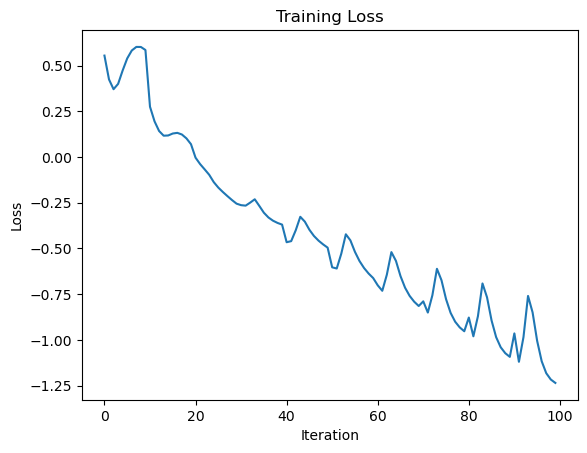

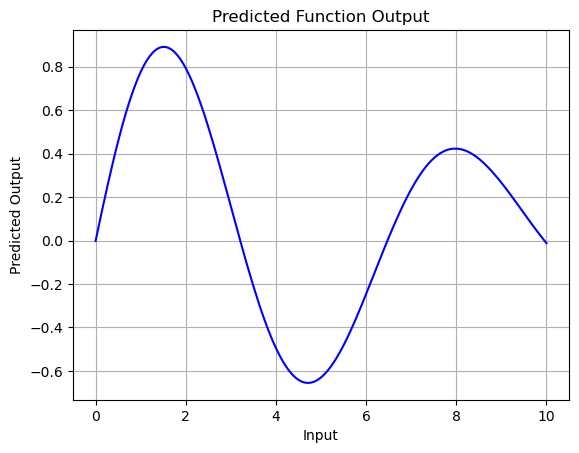

In [21]:
import numpy as np
import matplotlib.pyplot as plt

print(losses[-1])
plt.plot(np.log(losses[:100]))
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

# Assuming your model is already trained and you have test data x_test
x_test = np.linspace(0, 10,150)
x_test_2 = np.linspace(0, 10, 150)
x_test_tensor = torch.FloatTensor(x_test).unsqueeze(1)  # Convert to PyTorch tensor


# Perform prediction
with torch.no_grad():
    model.eval()  # Set the model to evaluation mode
    predictions = model(x_test_tensor)

# Convert tensors to numpy arrays for plotting

predictions_np = predictions.numpy()

# Plot the predicted outputs


plt.plot(x_test, predictions_np, color='b') 
plt.xlabel('Input')
plt.ylabel('Predicted Output')
plt.title('Predicted Function Output')
plt.grid(True)
plt.show()

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.func import functional_call, grad, vmap


X_BOUNDARY = 0.0  # boundary condition coordinate
F_BOUNDARY = 0.0  # boundary condition value

X_BOUNDARY_2 = 0.0  # boundary condition coordinate
DF_BOUNDARY_2 = 1.0  # boundary condition value

class LinearNN(nn.Module):
    def __init__(
        self,
        num_inputs: int = 1,
        num_layers: int = 2,
        num_neurons: int = [64,64],
        act: nn.Module = nn.Tanh(),
    ) -> None:
        super().__init__()
        self.num_inputs = num_inputs
        self.num_neurons = num_neurons
        self.num_layers = num_layers

        layers = []
        layers.append(nn.Linear(self.num_inputs, num_neurons[0]))

        for i in range(1, num_layers):  # Loop through the remaining layers
            layers.extend([nn.Linear(num_neurons[i-1], num_neurons[i]), act])

        layers.append(nn.Linear(num_neurons[-1], 1))  # Last layer
        self.network = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.network(x.reshape(-1, 1)).squeeze()

model = LinearNN()

def f(x: torch.Tensor, params: dict[str, torch.nn.Parameter]) -> torch.Tensor:
    return functional_call(model, params, (x, ))

dfdx = vmap(grad(f), in_dims=(0, None))

df2dx2 = vmap(grad(grad(f)), in_dims=(0, None))


x_boundary = torch.tensor([X_BOUNDARY])
f_boundary = torch.tensor([F_BOUNDARY])

x_boundary_2 = torch.tensor([X_BOUNDARY_2])  # Added second boundary condition coordinate
df_boundary_2 = torch.tensor([DF_BOUNDARY_2])  # Added second boundary condition value

a = 1
b = 1
c = 1
def loss_fn(params: dict[str, torch.nn.Parameter], x: torch.Tensor) -> torch.Tensor:
    f_value = f(x, params)
    interior = df2dx2(x, params) + f_value
    boundary = f(x_boundary, params) - f_boundary
    boundary_2 = dfdx(x_boundary_2, params) - df_boundary_2

    loss = nn.MSELoss()

    loss_value = a*loss(interior, torch.zeros_like(interior)) + \
                 b*loss(boundary, torch.zeros_like(boundary)) + \
                 c*loss(boundary_2, torch.zeros_like(boundary_2))
    return loss_value



optimizer = optim.Adam(model.parameters(), lr=0.0001)
params = dict(model.named_parameters())

# Training 

batch_size = 100
num_epochs = 50000
x  = torch.linspace(-2.0, 12.0,batch_size)


losses = []

for i in range(num_epochs):


    loss = loss_fn(params, x)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(float(loss))
    #print(f"Iteration {i} with loss {float(loss)}")
print("Training Done")

Training Done


7.128791139621171e-07


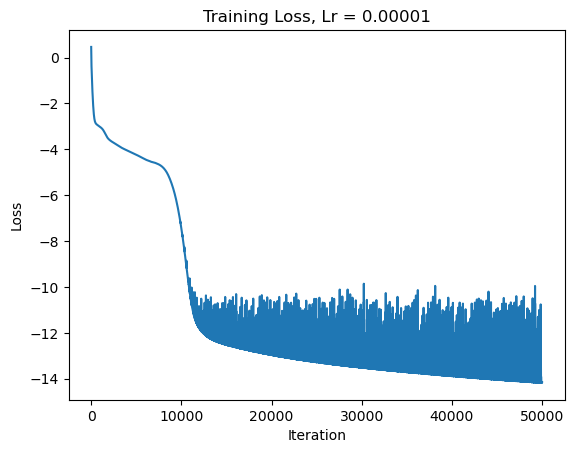

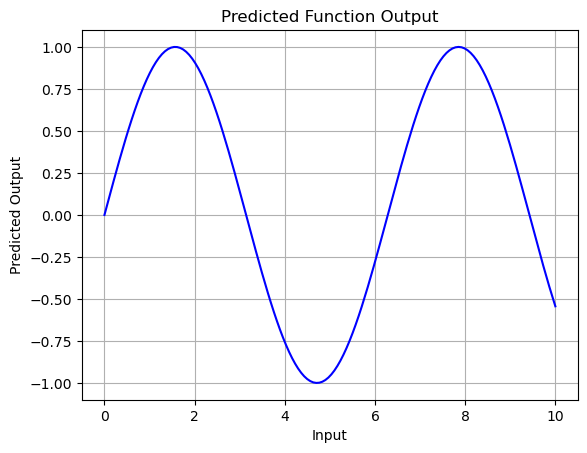

In [18]:
import numpy as np
import matplotlib.pyplot as plt

print(losses[-1])
plt.plot(np.log(losses))
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss, Lr = 0.00001')
plt.show()

# Assuming your model is already trained and you have test data x_test
x_test = np.linspace(0, 10,150)
x_test_tensor = torch.FloatTensor(x_test).unsqueeze(1)  # Convert to PyTorch tensor



# Perform prediction
with torch.no_grad():
    
    model.eval()  # Set the model to evaluation mode
    predictions = model(x_test_tensor)

# Convert tensors to numpy arrays for plotting

predictions_np = predictions.numpy()

# Plot the predicted outputs

plt.plot(x_test, predictions_np, color='b')
plt.xlabel('Input')
plt.ylabel('Predicted Output')
plt.title('Predicted Function Output')
plt.grid(True)
plt.show()